# **Time Series Project**


In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

## Load Data

Dataset = Monthly average temperature around Aomori City, Aomori Prefecture, Japan from January 1882 to December 2019.

In [2]:
#importing data
df = pd.read_csv('monthly_temperature_aomori_city.csv')
df

,year,month,temperature
0,1882,1,-0.4
1,1882,2,-0.6
2,1882,3,1.2
3,1882,4,8.9
4,1882,5,12.1
...,...,...,...
1663,2020,8,25.2
1664,2020,9,21.3
1665,2020,10,13.7
1666,2020,11,8.0


In [3]:
df.columns

Index(['year', 'month', 'temperature'], dtype='object')

In [4]:
df.shape

(1668, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1668 entries, 0 to 1667
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         1668 non-null   int64  
 1   month        1668 non-null   int64  
 2   temperature  1668 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 39.2 KB


## Data Cleansing

In [6]:
df.isna().sum()

year           0
month          0
temperature    0
dtype: int64

In [7]:
df = df[['year','temperature']]
df

,year,temperature
0,1882,-0.4
1,1882,-0.6
2,1882,1.2
3,1882,8.9
4,1882,12.1
...,...,...
1663,2020,25.2
1664,2020,21.3
1665,2020,13.7
1666,2020,8.0


## Split Data

In [8]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
# get data values
year = df['year'].values
temp = df['temperature'].values

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(temp, year, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(x_train), len(x_test))

1334 334


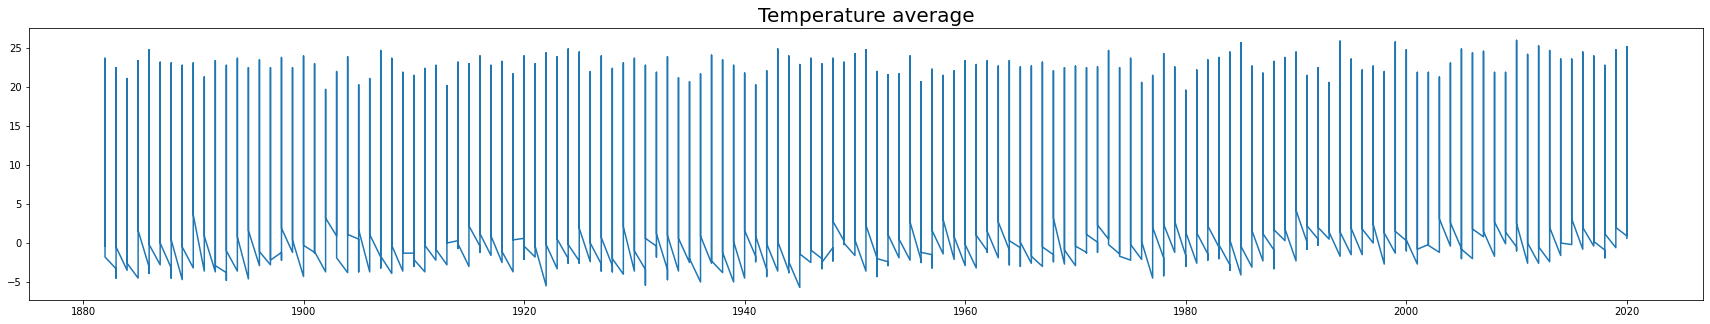

In [11]:
plt.figure(figsize=(30,5))

plt.plot(year, temp)
plt.title('Temperature average',
          fontsize=20);

## Modelling

In [12]:
from keras.layers import Dense, LSTM

data_x_train = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=5000)
data_x_test = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=5000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [13]:
max = df['temperature'].max()
print(max)

26.0


In [14]:
min = df['temperature'].min()
print(min)

-5.7


In [15]:
x = (26.0 - -5.7) * (10 / 100)
print(x)

3.17


In [16]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< x):
      self.model.stop_training = True
      print("\nMAE of the model < 10% of data scale")
callbacks = myCallback()

In [17]:
history = model.fit(data_x_train ,epochs=100, validation_data=data_x_test, callbacks=[callbacks])

Epoch 1/100
13/13 [==============================] - 5s 159ms/step - loss: 13.5854 - mae: 14.0782 - val_loss: 14.7457 - val_mae: 15.2386
Epoch 2/100
13/13 [==============================] - 1s 96ms/step - loss: 13.3794 - mae: 13.8721 - val_loss: 14.4890 - val_mae: 14.9812
Epoch 3/100
13/13 [==============================] - 1s 98ms/step - loss: 13.1167 - mae: 13.6091 - val_loss: 14.2111 - val_mae: 14.7035
Epoch 4/100
13/13 [==============================] - 1s 97ms/step - loss: 12.8443 - mae: 13.3363 - val_loss: 13.9426 - val_mae: 14.4351
Epoch 5/100
13/13 [==============================] - 1s 95ms/step - loss: 12.5802 - mae: 13.0719 - val_loss: 13.6814 - val_mae: 14.1741
Epoch 6/100
13/13 [==============================] - 1s 97ms/step - loss: 12.3245 - mae: 12.8162 - val_loss: 13.4254 - val_mae: 13.9179
Epoch 7/100
13/13 [==============================] - 1s 96ms/step - loss: 12.0751 - mae: 12.5664 - val_loss: 13.1748 - val_mae: 13.6670
Epoch 8/100
13/13 [============================

## Plotting

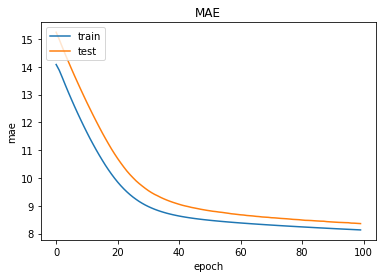

In [18]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

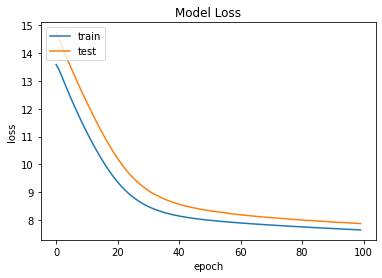

In [19]:
# plot of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()